In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver12.csv")
df2 = pd.read_csv("data/2026_FA예정_타자.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수 정의
def preprocess(df):
    df = df.copy()
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)
    return df

df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_15488\3216511609.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


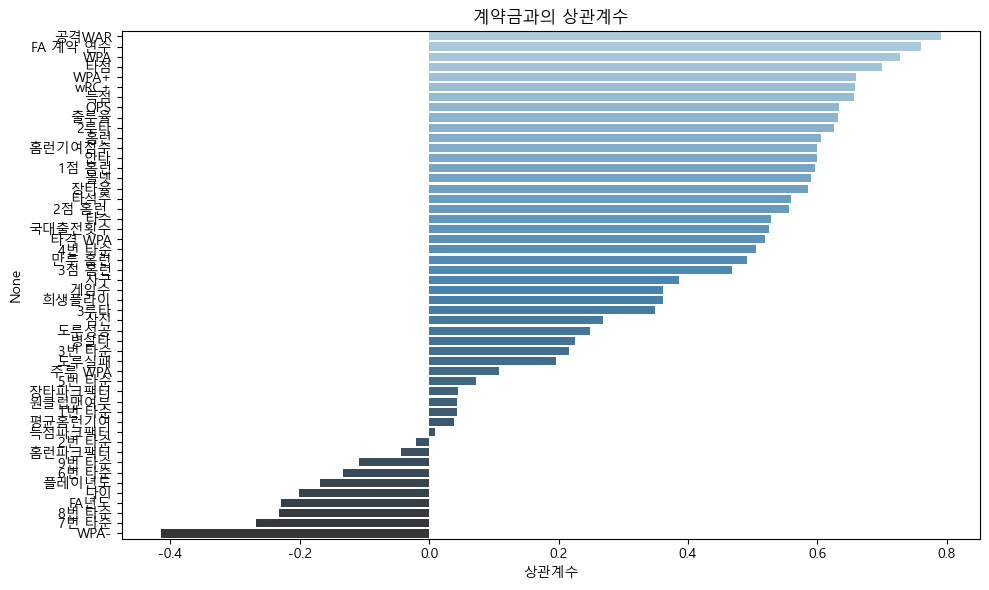

In [5]:
# 상관계수 및 가중치 계산
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.tight_layout()
plt.show()

In [6]:
# 예측에 사용할 피처 선택
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df2_cleaned[predict_features]

In [7]:
# Optuna로 하이퍼파라미터 튜닝
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20]),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [2, 5]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2]),
        'max_features': trial.suggest_categorical('max_features', ['sqrt']),
        'random_state': 42,
        'n_jobs': -1
    }
    model = RandomForestRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-08-06 15:39:03,479] A new study created in memory with name: no-name-1ffabb75-587f-4d21-b7b8-5ff4c0acb911
[I 2025-08-06 15:39:03,935] Trial 0 finished with value: 116891.86092553307 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 116891.86092553307.
[I 2025-08-06 15:39:05,026] Trial 1 finished with value: 113242.53674205735 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 113242.53674205735.
[I 2025-08-06 15:39:06,771] Trial 2 finished with value: 113011.92875836052 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 2 with value: 113011.92875836052.
[I 2025-08-06 15:39:07,198] Trial 3 finished with value: 116891.86092553307 and parameters: {'n_estimators': 100, 'max_depth': 10, 'm

In [8]:
# 최적 모델 학습 및 검증
best_params = study.best_params
best_model = RandomForestRegressor(**best_params)
best_model.fit(X_train, y_train)


print("[RandomForest + Optuna] 최적 파라미터:")
print(best_params)

val_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, val_pred) 
rmse = mean_squared_error(y_val, val_pred, squared=False)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

print(f"[모델 평가 지표]")
print(f" MSE : {mse:,.2f}")
print(f" RMSE: {rmse:,.2f}")
print(f" MAE : {mae:,.2f}")
print(f" R²  : {r2:.4f}")

[RandomForest + Optuna] 최적 파라미터:
{'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
[모델 평가 지표]
 MSE : 20,824,635,422.16
 RMSE: 144,307.43
 MAE : 78,974.09
 R²  : 0.5926


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
# 계약금 예측 및 반올림
df2_cleaned['계약금'] = best_model.predict(X_test).round(0).astype(int)

C:\Users\Lee\AppData\Local\Temp\ipykernel_15488\773722655.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='컬럼명', x='중요도 (RandomForest)', palette='YlOrRd')


피처 중요도 (RandomForest + Optuna):
       컬럼명  중요도 (RandomForest)  상관계수 기반 가중치
0    공격WAR            0.144055     0.040855
17  국대출전횟수            0.082573     0.027093
5       득점            0.059275     0.033944
3     WPA+            0.043198     0.034056
2       타점            0.042592     0.036160
1      WPA            0.035642     0.037568
18  타격 WPA            0.035500     0.026799
4     wRC+            0.034255     0.033973
8      2루타            0.032315     0.032353
7      출루율            0.032048     0.032661
15     타석수            0.026554     0.028906
6      OPS            0.025386     0.032738
39   9번 타순            0.023899     0.005563
14     장타율            0.023599     0.030230
12   1점 홈런            0.021652     0.030799
27    도루성공            0.021299     0.012825
46    WPA-            0.019517     0.021428
9       홈런            0.019436     0.031318
24   희생플라이            0.016871     0.018636
42      나이            0.016666     0.010384
16      타수            0.016203     0.027303


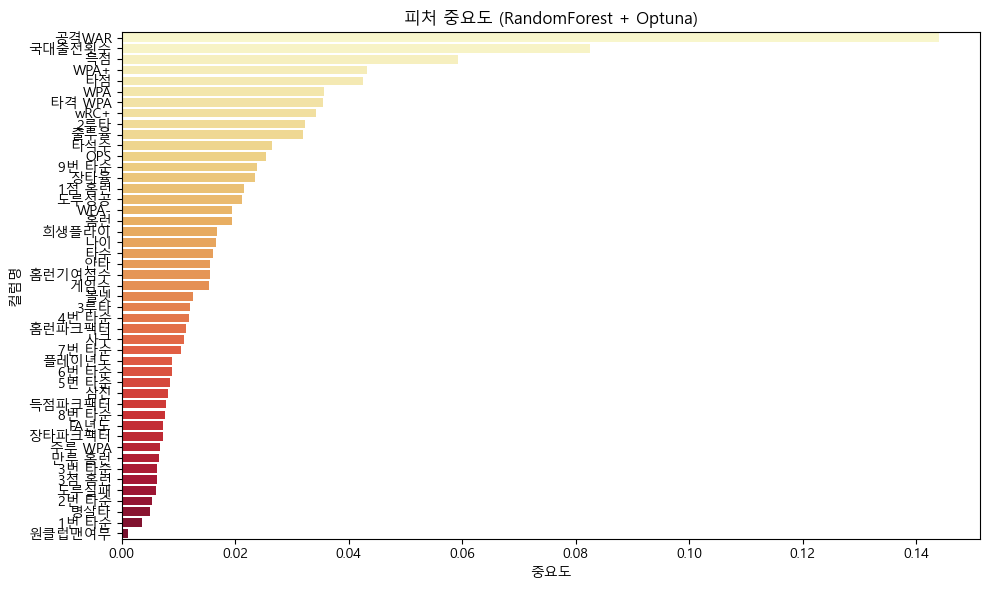

In [10]:
# 피처 중요도 분석
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (RandomForest)': best_model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (RandomForest)', ascending=False)

print("피처 중요도 (RandomForest + Optuna):")
print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, y='컬럼명', x='중요도 (RandomForest)', palette='YlOrRd')
plt.title('피처 중요도 (RandomForest + Optuna)')
plt.xlabel('중요도')
plt.tight_layout()
plt.show()

In [11]:
# 예측 결과 출력
print("예측 계약금 상위 선수 (RandomForest + Optuna):")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='선수명', ascending=True))

예측 계약금 상위 선수 (RandomForest + Optuna):
    선수명     계약금
0   강민호  214440
1   강백호  118078
2   김재환  217355
3   박병호  181972
4   박승욱   40717
5   박찬호  193234
6   박해민  207016
7   손아섭  178202
8   이재원   56433
9   장성우  163382
10   정훈   42686
11  조수행   44255
12  최원준  148036
13  최형우  227071
14  황재균  148008
